# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [15]:
import pandas as pd

# Set max columns to display for full visibility
pd.set_option('display.max_columns', 1000)

# Load data from CSV file using semicolon delimiter
dataset = pd.read_csv('secondary_data.csv', delimiter=';')

# Preview the first few rows
dataset.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

# Informed data preparation.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score, make_scorer, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Display more columns for better overview
pd.set_option('display.max_columns', 100)

# Load dataset
data = pd.read_csv('secondary_data.csv', delimiter=';')

# Separate predictors and target label
features = data.drop(columns=["class"])
target = data["class"]

# Initial train-test split (80/20), stratified by target
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

# Merge features and target for preprocessing
prep_data = X_temp.copy()
prep_data["class"] = y_temp

# Column groupings
num_features = ["cap-diameter", "stem-height", "stem-width"]
cat_features = [
    "cap-shape", "cap-color", "cap-surface",
    "gill-attachment", "gill-spacing", "gill-color",
    "stem-surface", "stem-color", "veil-type",
    "veil-color", "ring-type", "spore-print-color",
    "habitat", "season", "stem-root"
]

# Handle missing numeric data by median imputation
for feature in num_features:
    prep_data[feature] = prep_data[feature].fillna(prep_data[feature].median())

# Handle missing categorical data by mode
for feature in cat_features:
    prep_data[feature] = prep_data[feature].fillna(prep_data[feature].mode()[0])

# Encode binary flags (true/false to 1/0)
binary_flags = ["does-bruise-or-bleed", "has-ring"]
for flag in binary_flags:
    prep_data[flag] = prep_data[flag].map({"t": 1, "f": 0})

# One-hot encode remaining categorical variables
one_hot_targets = list(set(cat_features) - set(binary_flags))
prep_data = pd.get_dummies(prep_data, columns=one_hot_targets, drop_first=True)

# Scale numeric variables to standard normal
scaler = StandardScaler()
prep_data[num_features] = scaler.fit_transform(prep_data[num_features])

# Split processed data again: 75% train / 25% validation
X_final_train, X_validation, y_final_train, y_validation = train_test_split(
    prep_data.drop(columns=["class"]), prep_data["class"],
    test_size=0.25, random_state=42, stratify=prep_data["class"]
)


# 2 different classification models, one of which must be logistic regression.
## A discussion of which performance metric is most relevant for the evaluation of your models.
## 2 different validation methodologies used to tune hyperparameters.
## Confusion matrices for your models, and associated comments.

Logistic Regression Best Hyperparameters: {'C': 0.01, 'penalty': 'l1'}

Logistic Regression Results (Validation Set):
              precision    recall  f1-score   support

           e       0.81      0.77      0.79      5436
           p       0.82      0.85      0.84      6778

    accuracy                           0.82     12214
   macro avg       0.82      0.81      0.81     12214
weighted avg       0.82      0.82      0.82     12214


Logistic Regression Confusion Matrix Insights:
TN (e→e): 4195
FP (e→p): 1241
FN (p→e): 995
TP (p→p): 5783
Accuracy: 0.82


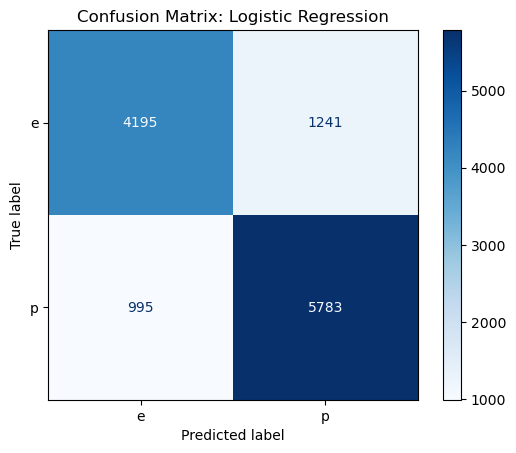


Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_split': 2}

Decision Tree Validation Results:
              precision    recall  f1-score   support

           e       0.85      0.89      0.87      5436
           p       0.91      0.88      0.89      6778

    accuracy                           0.88     12214
   macro avg       0.88      0.88      0.88     12214
weighted avg       0.88      0.88      0.88     12214


Decision Tree Confusion Matrix Details:
TN (e→e): 4848
FP (e→p): 588
FN (p→e): 838
TP (p→p): 5940
Accuracy: 0.88


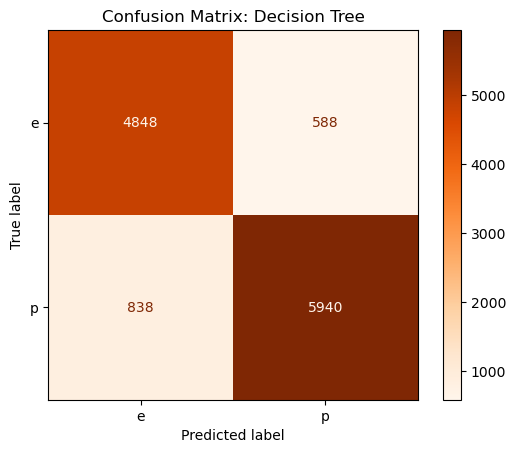

In [20]:

# Evaluation Focus:
# The recall metric is selected due to its focus on identifying all actual 
# positive cases ('p'). This is especially important in domains like health or 
# fraud detection where false negatives are costly.

# Model 1: Logistic Regression + CV
# Validation: 5-Fold CV with GridSearch
# Goal: Maximize Recall

log_model = LogisticRegression(solver='liblinear')  # suitable for small datasets

log_hyperparams = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Custom scoring metric targeting positive class
recall_metric = make_scorer(recall_score, pos_label='p')
log_cv = GridSearchCV(log_model, log_hyperparams, cv=5, scoring=recall_metric)
log_cv.fit(X_final_train, y_final_train)

print("Logistic Regression Best Hyperparameters:", log_cv.best_params_)

best_log_model = log_cv.best_estimator_

# Validate on hold-out set
log_preds = best_log_model.predict(X_validation)

print("\nLogistic Regression Results (Validation Set):")
print(classification_report(y_validation, log_preds))

# Confusion matrix breakdown
log_cm = confusion_matrix(y_validation, log_preds, labels=['e', 'p'])
tn, fp, fn, tp = log_cm.ravel()
acc = (tn + tp) / np.sum(log_cm)

print("\nLogistic Regression Confusion Matrix Insights:")
print(f"TN (e→e): {tn}")
print(f"FP (e→p): {fp}")
print(f"FN (p→e): {fn}")
print(f"TP (p→p): {tp}")
print(f"Accuracy: {acc:.2f}")

# Confusion matrix plot
ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=['e', 'p']).plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.grid(False)
plt.show()


# Model 2: Decision Tree + Manual Validation
# Tuning Method: Manual grid search
# Metric: Recall

tree_model = DecisionTreeClassifier(random_state=42)
tree_params = {
    'max_depth': [10],
    'min_samples_split': [2, 5, 10]
}

top_recall = 0
optimal_tree_config = {}

for depth in tree_params['max_depth']:
    for split in tree_params['min_samples_split']:
        temp_tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, random_state=42)
        temp_tree.fit(X_final_train, y_final_train)
        temp_preds = temp_tree.predict(X_validation)
        recall = recall_score(y_validation, temp_preds, pos_label='p')
        if recall > top_recall:
            top_recall = recall
            optimal_tree_config = {'max_depth': depth, 'min_samples_split': split}

print("\nBest Decision Tree Parameters:", optimal_tree_config)

final_tree = DecisionTreeClassifier(**optimal_tree_config, random_state=42)
final_tree.fit(X_final_train, y_final_train)
tree_preds = final_tree.predict(X_validation)

print("\nDecision Tree Validation Results:")
print(classification_report(y_validation, tree_preds))

# Confusion matrix breakdown for decision tree
tree_cm = confusion_matrix(y_validation, tree_preds, labels=['e', 'p'])
tn_dt, fp_dt, fn_dt, tp_dt = tree_cm.ravel()
acc_dt = (tn_dt + tp_dt) / np.sum(tree_cm)

print("\nDecision Tree Confusion Matrix Details:")
print(f"TN (e→e): {tn_dt}")
print(f"FP (e→p): {fp_dt}")
print(f"FN (p→e): {fn_dt}")
print(f"TP (p→p): {tp_dt}")
print(f"Accuracy: {acc_dt:.2f}")

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=tree_cm, display_labels=['e', 'p']).plot(cmap='Oranges')
plt.title("Confusion Matrix: Decision Tree")
plt.grid(False)
plt.show()


# Summary:
# Two classification models were evaluated:
#   • Logistic Regression with automated CV tuning
#   • Decision Tree with manual hyperparameter validation
# The focus on recall emphasizes catching all 'positive' cases,
# and confusion matrices help explore the models' strengths/weaknesses.

